In [43]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,mean_absolute_percentage_error
from tqdm import tqdm
import math 

In [44]:
# with open('inputs_36.pkl', 'rb') as f, open('targets_36.pkl','rb') as t:
#     inputs = pickle.load(f)
#     targets = pickle.load(t)
# # Shuffle before splitting (preserves alignment of X and y)
# X_shuffled, y_shuffled = shuffle(inputs, targets, random_state=42)

# # Train-test split
# X_train, X_test, Y_train, Y_test = train_test_split(
#     X_shuffled, y_shuffled, test_size=0.2, random_state=42
# )
# # X_train, X_test, y_train, y_test = train_test_split(
# #     X_train, y_train, test_size=0.2, random_state=42
# # )


In [45]:
# with open("inputs_small_train_36.pkl", "wb") as f:
#     pickle.dump(X_train, f)

# with open("inputs_small_test_36.pkl", "wb") as f:
#     pickle.dump(X_test, f)
# # Save targets
# with open("targets_small_train_36.pkl", "wb") as f:
#     pickle.dump(y_train, f)
# with open("targets_small_test_36.pkl", "wb") as f:
#     pickle.dump(y_test, f)

In [46]:
with open('/home/f20222001/test-venv/UHI/Datasets_processed/inputs_36.pkl', 'rb') as f, open('/home/f20222001/test-venv/UHI/Datasets_processed/targets_36.pkl','rb') as t:
    inputs = pickle.load(f)
    targets = pickle.load(t)
# Shuffle before splitting (preserves alignment of X and y)
X_shuffled, y_shuffled = shuffle(inputs, targets, random_state=42)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X_shuffled, y_shuffled, test_size=0.2, random_state=42
)
# X_train, X_test, y_train, y_test = train_test_split(
#     X_train, y_train, test_size=0.2, random_state=42
# )


In [47]:
# Indexes of features to normalize
norm_idx = [0, 1, 2, 3]  # NDVI, NDBI, Albedo, agg_month (example)

# Flatten X for scaling
X_train_flat = X_train.reshape(-1, X_train.shape[2])
X_test_flat = X_test.reshape(-1, X_test.shape[2])

# Copy to preserve original
X_train_scaled = X_train_flat.copy()
X_test_scaled = X_test_flat.copy()

# Standard scaler for features
standard_scaler_X = StandardScaler()
X_train_scaled[:, norm_idx] = standard_scaler_X.fit_transform(X_train_flat[:, norm_idx])
X_test_scaled[:, norm_idx] = standard_scaler_X.transform(X_test_flat[:, norm_idx])

# Reshape back to original 3D shape
X_train = X_train_scaled.reshape(X_train.shape)
X_test = X_test_scaled.reshape(X_test.shape)

# --- Target Scaling (y) ---
# Flatten y in case it's 3D or 2D
y_train_flat = Y_train.reshape(-1, 1)
y_test_flat = Y_test.reshape(-1, 1)

standard_scaler_y = StandardScaler()
y_train_scaled = standard_scaler_y.fit_transform(y_train_flat)
y_test_scaled = standard_scaler_y.transform(y_test_flat)

# Reshape back to original shape
Y_train = y_train_scaled.reshape(Y_train.shape)
Y_test = y_test_scaled.reshape(Y_test.shape)


In [48]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0)]


In [49]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [50]:
X_train.shape

(487502, 12, 17)

In [51]:
X_train

array([[[ 8.62006128e-01,  1.30156979e-01,  1.25853792e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.92296588e-01, -4.58048843e-02,  1.36475578e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 8.83926079e-02, -2.00183734e-01,  1.23975918e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-3.64894867e+00, -3.26838464e-01,  2.98603754e-02, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 3.98082346e-01,  3.98319028e-02,  1.54238477e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 5.81018887e-02, -2.56466150e-01,  1.08231835e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 1.27319708e-01,  3.59979928e-01, -1.32668391e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.33512661e-01,  4.29130048e-01, -1.71790630e-01, ...,
          0.00000000e+00,  0.00000000e

In [52]:
Y_train.shape

(487502,)

In [53]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(Y_train, dtype=torch.float32))

test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                             torch.tensor(Y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


In [54]:
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.2):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_fc = nn.Linear(d_model, 1)  # regression output

    def forward(self, src):
        # src: (batch_size, seq_len, input_dim)
        src = src.permute(1, 0, 2)  # (seq_len, batch_size, input_dim)
        src = self.input_fc(src)   # (seq_len, batch_size, d_model)
        src = self.pos_encoder(src)
        transformer_out = self.transformer_encoder(src)  # (seq_len, batch_size, d_model)
        out = transformer_out[-1]  # take last time step
        return self.output_fc(out).squeeze(-1)


/home/f20222001/test-venv/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:11<19:40, 11.92s/it]

Epoch 1/100 - Train Loss: 0.7816957235336304


  2%|▏         | 2/100 [00:24<19:50, 12.15s/it]

Epoch 2/100 - Train Loss: 1.2372982501983643


  3%|▎         | 3/100 [00:36<19:39, 12.16s/it]

Epoch 3/100 - Train Loss: 0.11857356876134872


  4%|▍         | 4/100 [00:48<19:32, 12.21s/it]

Epoch 4/100 - Train Loss: 1.0078548192977905


  5%|▌         | 5/100 [01:00<19:18, 12.19s/it]

Epoch 5/100 - Train Loss: 0.13209335505962372


  6%|▌         | 6/100 [01:13<19:09, 12.22s/it]

Epoch 6/100 - Train Loss: 0.8319498896598816


  7%|▋         | 7/100 [01:25<18:58, 12.24s/it]

Epoch 7/100 - Train Loss: 0.3000629246234894


  8%|▊         | 8/100 [01:37<18:45, 12.24s/it]

Epoch 8/100 - Train Loss: 0.40312719345092773


  9%|▉         | 9/100 [01:49<18:32, 12.22s/it]

Epoch 9/100 - Train Loss: 0.5516405701637268


 10%|█         | 10/100 [02:02<18:24, 12.27s/it]

Epoch 10/100 - Train Loss: 0.5850315690040588


 11%|█         | 11/100 [02:14<18:14, 12.30s/it]

Epoch 11/100 - Train Loss: 0.4061339497566223


 12%|█▏        | 12/100 [02:26<17:47, 12.13s/it]

Epoch 12/100 - Train Loss: 0.47983863949775696


 13%|█▎        | 13/100 [02:38<17:26, 12.03s/it]

Epoch 13/100 - Train Loss: 0.26965245604515076


 14%|█▍        | 14/100 [02:50<17:17, 12.07s/it]

Epoch 14/100 - Train Loss: 0.5239652991294861


 15%|█▌        | 15/100 [03:02<17:06, 12.08s/it]

Epoch 15/100 - Train Loss: 0.5287750363349915


 16%|█▌        | 16/100 [03:14<16:59, 12.13s/it]

Epoch 16/100 - Train Loss: 0.30831781029701233


 17%|█▋        | 17/100 [03:26<16:51, 12.19s/it]

Epoch 17/100 - Train Loss: 0.1857220083475113


 18%|█▊        | 18/100 [03:39<16:43, 12.23s/it]

Epoch 18/100 - Train Loss: 0.27849942445755005


 19%|█▉        | 19/100 [03:51<16:22, 12.12s/it]

Epoch 19/100 - Train Loss: 0.8469046950340271


 20%|██        | 20/100 [04:03<16:03, 12.04s/it]

Epoch 20/100 - Train Loss: 0.854261577129364


 21%|██        | 21/100 [04:15<15:51, 12.04s/it]

Epoch 21/100 - Train Loss: 0.5095996260643005


 22%|██▏       | 22/100 [04:27<15:44, 12.11s/it]

Epoch 22/100 - Train Loss: 0.7554839849472046


 23%|██▎       | 23/100 [04:39<15:27, 12.05s/it]

Epoch 23/100 - Train Loss: 0.3357032537460327


 24%|██▍       | 24/100 [04:51<15:19, 12.10s/it]

Epoch 24/100 - Train Loss: 0.216104656457901


 25%|██▌       | 25/100 [05:03<15:05, 12.08s/it]

Epoch 25/100 - Train Loss: 0.08656933158636093


 26%|██▌       | 26/100 [05:15<14:56, 12.11s/it]

Epoch 26/100 - Train Loss: 0.4589860439300537


 27%|██▋       | 27/100 [05:27<14:47, 12.16s/it]

Epoch 27/100 - Train Loss: 0.35504817962646484


 28%|██▊       | 28/100 [05:40<14:40, 12.22s/it]

Epoch 28/100 - Train Loss: 0.5388752818107605


 29%|██▉       | 29/100 [05:52<14:30, 12.26s/it]

Epoch 29/100 - Train Loss: 0.893143892288208


 30%|███       | 30/100 [06:04<14:19, 12.27s/it]

Epoch 30/100 - Train Loss: 0.8577686548233032


 31%|███       | 31/100 [06:17<14:06, 12.27s/it]

Epoch 31/100 - Train Loss: 0.49784713983535767


 32%|███▏      | 32/100 [06:29<13:47, 12.16s/it]

Epoch 32/100 - Train Loss: 0.4455091059207916


 33%|███▎      | 33/100 [06:41<13:39, 12.23s/it]

Epoch 33/100 - Train Loss: 0.3727416396141052


 34%|███▍      | 34/100 [06:53<13:27, 12.24s/it]

Epoch 34/100 - Train Loss: 1.0145225524902344


 35%|███▌      | 35/100 [07:05<13:13, 12.21s/it]

Epoch 35/100 - Train Loss: 0.47659948468208313


 36%|███▌      | 36/100 [07:17<12:56, 12.13s/it]

Epoch 36/100 - Train Loss: 0.9571969509124756


 37%|███▋      | 37/100 [07:30<12:47, 12.18s/it]

Epoch 37/100 - Train Loss: 0.3237076699733734


 38%|███▊      | 38/100 [07:42<12:38, 12.23s/it]

Epoch 38/100 - Train Loss: 0.4431231617927551


 39%|███▉      | 39/100 [07:54<12:27, 12.26s/it]

Epoch 39/100 - Train Loss: 0.0713580846786499


 40%|████      | 40/100 [08:07<12:16, 12.28s/it]

Epoch 40/100 - Train Loss: 0.30053848028182983


 41%|████      | 41/100 [08:19<12:04, 12.28s/it]

Epoch 41/100 - Train Loss: 0.4297126829624176


 42%|████▏     | 42/100 [08:31<11:48, 12.21s/it]

Epoch 42/100 - Train Loss: 0.8539208769798279


 43%|████▎     | 43/100 [08:43<11:36, 12.22s/it]

Epoch 43/100 - Train Loss: 0.24466192722320557


 44%|████▍     | 44/100 [08:56<11:24, 12.23s/it]

Epoch 44/100 - Train Loss: 0.2819955050945282


 45%|████▌     | 45/100 [09:08<11:09, 12.17s/it]

Epoch 45/100 - Train Loss: 0.4716565012931824


 46%|████▌     | 46/100 [09:19<10:50, 12.04s/it]

Epoch 46/100 - Train Loss: 0.37502846121788025


 47%|████▋     | 47/100 [09:31<10:33, 11.96s/it]

Epoch 47/100 - Train Loss: 0.03745323047041893


 48%|████▊     | 48/100 [09:43<10:22, 11.97s/it]

Epoch 48/100 - Train Loss: 0.5126446485519409


 49%|████▉     | 49/100 [09:55<10:14, 12.05s/it]

Epoch 49/100 - Train Loss: 0.4073562026023865


 50%|█████     | 50/100 [10:07<09:56, 11.93s/it]

Epoch 50/100 - Train Loss: 1.1925534009933472


 51%|█████     | 51/100 [10:19<09:39, 11.82s/it]

Epoch 51/100 - Train Loss: 0.6400957107543945


 52%|█████▏    | 52/100 [10:31<09:31, 11.90s/it]

Epoch 52/100 - Train Loss: 0.05921358987689018


 53%|█████▎    | 53/100 [10:43<09:21, 11.96s/it]

Epoch 53/100 - Train Loss: 0.3629770576953888


 54%|█████▍    | 54/100 [10:55<09:12, 12.00s/it]

Epoch 54/100 - Train Loss: 0.49875324964523315


 55%|█████▌    | 55/100 [11:06<08:54, 11.88s/it]

Epoch 55/100 - Train Loss: 0.08067315816879272


 56%|█████▌    | 56/100 [11:18<08:38, 11.77s/it]

Epoch 56/100 - Train Loss: 0.5079398155212402


 57%|█████▋    | 57/100 [11:30<08:24, 11.72s/it]

Epoch 57/100 - Train Loss: 0.26349446177482605


 58%|█████▊    | 58/100 [11:41<08:10, 11.68s/it]

Epoch 58/100 - Train Loss: 0.08901359885931015


 59%|█████▉    | 59/100 [11:53<07:57, 11.64s/it]

Epoch 59/100 - Train Loss: 0.673964262008667


 60%|██████    | 60/100 [12:05<07:48, 11.72s/it]

Epoch 60/100 - Train Loss: 0.24963118135929108


 61%|██████    | 61/100 [12:17<07:44, 11.90s/it]

Epoch 61/100 - Train Loss: 0.06521431356668472


 62%|██████▏   | 62/100 [12:29<07:36, 12.02s/it]

Epoch 62/100 - Train Loss: 0.2882450222969055


 63%|██████▎   | 63/100 [12:42<07:28, 12.12s/it]

Epoch 63/100 - Train Loss: 0.21625469624996185


 64%|██████▍   | 64/100 [12:53<07:09, 11.94s/it]

Epoch 64/100 - Train Loss: 0.8026590943336487


 65%|██████▌   | 65/100 [13:04<06:51, 11.77s/it]

Epoch 65/100 - Train Loss: 0.9412906765937805


 66%|██████▌   | 66/100 [13:16<06:38, 11.71s/it]

Epoch 66/100 - Train Loss: 0.38245823979377747


 67%|██████▋   | 67/100 [13:28<06:31, 11.86s/it]

Epoch 67/100 - Train Loss: 0.33911100029945374


 68%|██████▊   | 68/100 [13:40<06:22, 11.95s/it]

Epoch 68/100 - Train Loss: 0.7644360661506653


 69%|██████▉   | 69/100 [13:53<06:13, 12.04s/it]

Epoch 69/100 - Train Loss: 0.2375078946352005


 70%|███████   | 70/100 [14:04<05:57, 11.92s/it]

Epoch 70/100 - Train Loss: 0.3729257881641388


 71%|███████   | 71/100 [14:16<05:47, 11.98s/it]

Epoch 71/100 - Train Loss: 0.3401010036468506


 72%|███████▏  | 72/100 [14:29<05:37, 12.06s/it]

Epoch 72/100 - Train Loss: 0.35675886273384094


 73%|███████▎  | 73/100 [14:40<05:23, 11.98s/it]

Epoch 73/100 - Train Loss: 0.39628392457962036


 74%|███████▍  | 74/100 [14:53<05:13, 12.05s/it]

Epoch 74/100 - Train Loss: 0.4194788932800293


 75%|███████▌  | 75/100 [15:04<04:59, 11.99s/it]

Epoch 75/100 - Train Loss: 0.18134558200836182


 76%|███████▌  | 76/100 [15:16<04:45, 11.92s/it]

Epoch 76/100 - Train Loss: 0.5789843201637268


 77%|███████▋  | 77/100 [15:28<04:36, 12.02s/it]

Epoch 77/100 - Train Loss: 0.6485890746116638


 78%|███████▊  | 78/100 [15:41<04:25, 12.09s/it]

Epoch 78/100 - Train Loss: 0.6114546060562134


 79%|███████▉  | 79/100 [15:53<04:15, 12.14s/it]

Epoch 79/100 - Train Loss: 0.7074486017227173


 80%|████████  | 80/100 [16:05<04:01, 12.09s/it]

Epoch 80/100 - Train Loss: 0.44978123903274536


 81%|████████  | 81/100 [16:17<03:49, 12.10s/it]

Epoch 81/100 - Train Loss: 0.564306378364563


 82%|████████▏ | 82/100 [16:29<03:38, 12.16s/it]

Epoch 82/100 - Train Loss: 0.38043662905693054


 83%|████████▎ | 83/100 [16:42<03:27, 12.19s/it]

Epoch 83/100 - Train Loss: 0.30749833583831787


 84%|████████▍ | 84/100 [16:54<03:15, 12.23s/it]

Epoch 84/100 - Train Loss: 0.22861452400684357


 85%|████████▌ | 85/100 [17:06<03:00, 12.04s/it]

Epoch 85/100 - Train Loss: 0.17771241068840027


 86%|████████▌ | 86/100 [17:18<02:48, 12.06s/it]

Epoch 86/100 - Train Loss: 0.20287063717842102


 87%|████████▋ | 87/100 [17:30<02:37, 12.15s/it]

Epoch 87/100 - Train Loss: 0.6019113063812256


 88%|████████▊ | 88/100 [17:42<02:25, 12.15s/it]

Epoch 88/100 - Train Loss: 0.638777494430542


 89%|████████▉ | 89/100 [17:55<02:14, 12.21s/it]

Epoch 89/100 - Train Loss: 0.6645057201385498


 90%|█████████ | 90/100 [18:07<02:02, 12.25s/it]

Epoch 90/100 - Train Loss: 0.24680396914482117


 91%|█████████ | 91/100 [18:19<01:50, 12.25s/it]

Epoch 91/100 - Train Loss: 0.18991175293922424


 92%|█████████▏| 92/100 [18:31<01:36, 12.07s/it]

Epoch 92/100 - Train Loss: 0.41074803471565247


 93%|█████████▎| 93/100 [18:42<01:23, 11.96s/it]

Epoch 93/100 - Train Loss: 0.4536779522895813


 94%|█████████▍| 94/100 [18:54<01:11, 11.84s/it]

Epoch 94/100 - Train Loss: 0.2881421446800232


 95%|█████████▌| 95/100 [19:06<00:58, 11.76s/it]

Epoch 95/100 - Train Loss: 0.4450376629829407


 96%|█████████▌| 96/100 [19:17<00:46, 11.66s/it]

Epoch 96/100 - Train Loss: 0.27561241388320923


 97%|█████████▋| 97/100 [19:29<00:35, 11.84s/it]

Epoch 97/100 - Train Loss: 0.6524433493614197


 98%|█████████▊| 98/100 [19:42<00:23, 11.97s/it]

Epoch 98/100 - Train Loss: 0.1973082274198532


 99%|█████████▉| 99/100 [19:54<00:12, 12.06s/it]

Epoch 99/100 - Train Loss: 0.16109168529510498


100%|██████████| 100/100 [20:06<00:00, 12.07s/it]

Epoch 100/100 - Train Loss: 0.19191138446331024


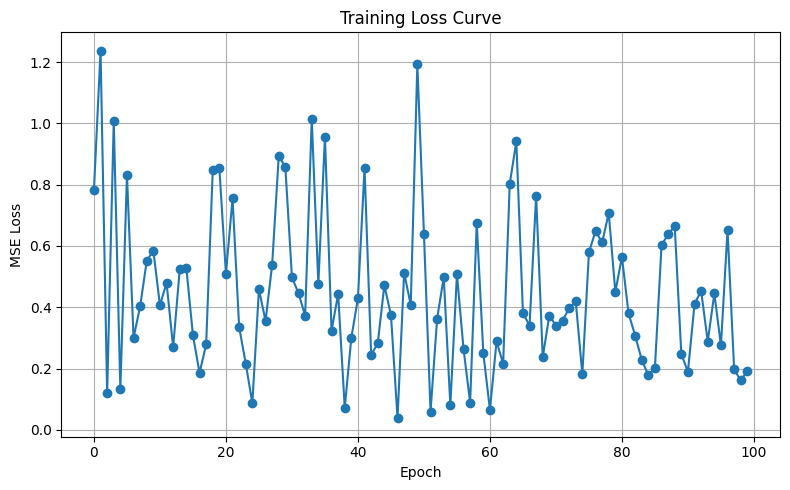

In [55]:
input_size = X_train.shape[2]  # num_features per timestep
model = TransformerRegressor(input_dim=input_size)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 100
train_losses = []
for epoch in tqdm(range(num_epochs)):
    model.train()

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        #print(batch_x.shape)
        #print(batch_y.shape)
        # Forward
        preds = model(batch_x)  # shape: (batch_size,)
        #print(preds.shape)
        loss = criterion(preds, batch_y)
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {loss.item()}")
    train_losses.append(loss.item())
plt.figure(figsize=(8, 5))
plt.plot(np.arange(num_epochs),train_losses, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        preds = model(batch_x)
        
        y_true.extend(batch_y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(y_true).reshape(-1, 1)
y_pred = np.array(y_pred).reshape(-1, 1)

# Unnormalize using RobustScaler
y_true = standard_scaler_y.inverse_transform(y_true)
y_pred = standard_scaler_y.inverse_transform(y_pred)

# Flatten back
y_true = y_true.flatten()
y_pred = y_pred.flatten()

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape=mean_absolute_percentage_error(y_true, y_pred)
print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test R²:   {r2:.4f}")
print(f"Test MAPE:   {mape:.4f}")


NameError: name 'model' is not defined

: 